# Exploration of model Results

In this notebook, we will explore the model results by varying a few parameters.

## Step 1. Import the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import model_proposal #AEM model location
import solvers #Solvers for some analysis from the aem model

-0.09132421054257657


## Step 2. Create and define the model

In [2]:
# Define model with hydraulic condutivity = 3 m/d, height = 20, reference river head = 18

aem_model = model_proposal.Model(k = 0.12e-3*3600*24, H = 85, h0 = 80)

# Add well at position x = 30, y = 50 and pumping rate of 250 m3/d, well radius = 0.1 m/d

well = model_proposal.Well(aem_model, Q = 0.044*3600*24, rw = 0.1, x = 63, y = 50)

# Solver for river length and river water capture fraction.

solv = solvers.river_length(aem_model)

print("River Capture Length, Capture position and contribution to discharge is:")
print(solv.solve_river_length())

length, riv_coords, capture_fraction = solv.solve_river_length()

tt = solv.time_travel(0.2)

River Capture Length, Capture position and contribution to discharge is:
(537.6484814037024, [-218.82424070185118, 318.8242407018512], 0.7120235184293046)


C:\Users\vcant\anaconda3\envs\flopy1\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\vcant\anaconda3\envs\flopy1\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


array([<AxesSubplot:xlabel='Travel time - Days', ylabel='y [m]'>,
       <AxesSubplot:xlabel='x [m]', ylabel='y [m]'>], dtype=object)

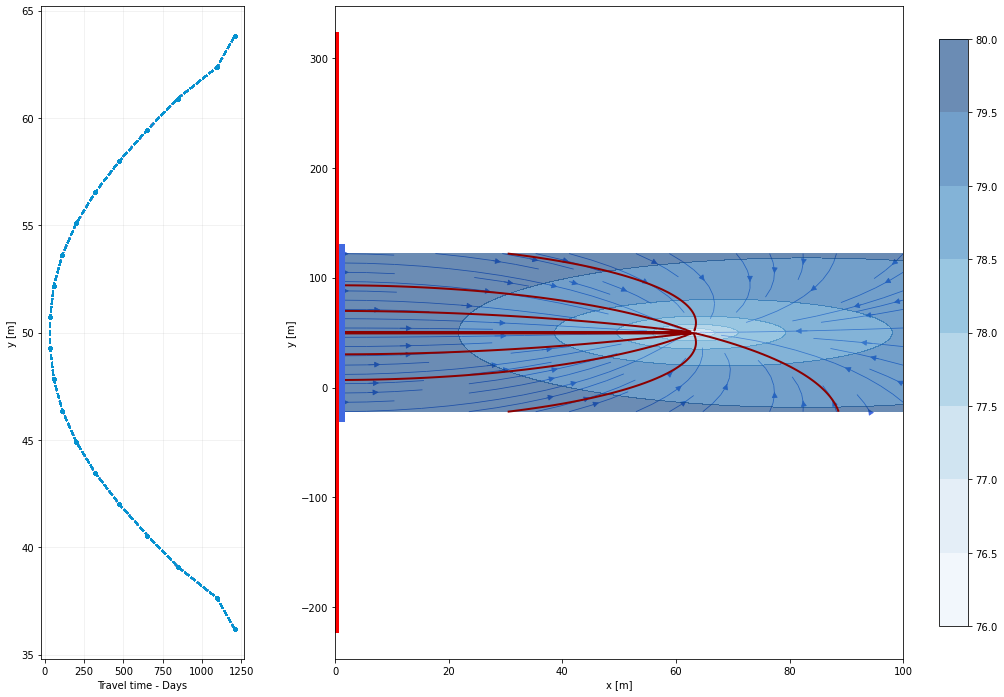

In [3]:
import plot

img = plot.plotting(0,100,[-220,320],100)

img.plot2d(aem_model, tt=tt,levels=8, quiver=False, streams=True)

## Step 3. Vary parameters and measure indicators

To measure the variability of the different aquifer matrix to the model results, we have to assume the aquifer head gradient is fixed, hence, when changing the hydraulic conductivity the base_flow would change as well.

In [4]:
# Setting up the dataframe with common average ks [m/s] for different aquifer matrix type
hk = pd.DataFrame({'matrix' : ['coarse gravel','gravel', 'coarse sand', 'medium sand', 'fine sand'],
                  'k_m_s' : [5e-3,1.5e-3,1e-3,6e-4,1e-4]})

# Converting k from [m/s] to [m/d]
hk['k_m_d'] = hk['k_m_s']*3600*24

To solve this problem we assume the specific baseflow using Darcy's Law:

$$ Q = k*\frac{\partial h}{\partial x} $$

Theferore the variation in baseflow will be linearly proportion to the variation in k.
The reference specific baseflow is 1 m2/d, for a k = 3 m/d.

$$ Q_n = \frac{Q_{reference}*k_n}{k_{reference}} $$

In [5]:
hk['baseflow'] = hk['k_m_d']*0.001*80

In [6]:
hk

,matrix,k_m_s,k_m_d,baseflow
0,coarse gravel,0.0050,432.00,34.5600
1,gravel,0.0015,129.60,10.3680
2,coarse sand,0.0010,86.40,6.9120
3,medium sand,0.0006,51.84,4.1472
4,fine sand,0.0001,8.64,0.6912


In [7]:
lengths = []
cap_fracs = []
tts = []

for k, base in zip(hk['k_m_d'], hk['baseflow']):
    
    aem_model = model_proposal.Model(k = k, H = 85, h0 = 80)
    
    aem_model.Qo_x = base

    # Add well at position

    well = model_proposal.Well(aem_model, Q = 0.044*3600*24, rw = 0.1, x = 63, y = 50)

    # Solver for river length and river water capture fraction.

    solv = solvers.river_length(aem_model)
    try:
        length, riv_coords, capture_fraction = solv.solve_river_length()
        tt = solv.time_travel(0.2, delta_s = 0.1)
    except:
        length = 0
        capture_fraction = 0
        tt = [0]
    
    lengths.append(length)
    cap_fracs.append(capture_fraction)
    tts.append(np.array(tt).min())
    

There are no stagnation points, check model inputs


C:\Users\vcant\anaconda3\envs\flopy1\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\vcant\anaconda3\envs\flopy1\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [8]:
hk['minimum travel time'] = tts
hk['river capture length'] = lengths
hk['capture fraction'] = cap_fracs

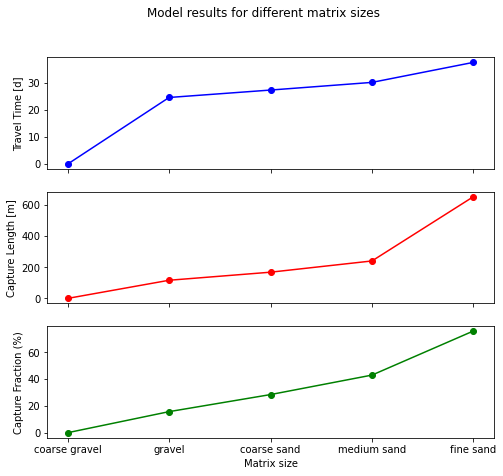

In [9]:
fig, axs = plt.subplots(3,1,sharex = True, figsize = (8,7))

axs[0].plot(hk['matrix'],hk['minimum travel time'], 'bo-')
axs[0].set_ylabel('Travel Time [d]')
axs[1].plot(hk['river capture length'], 'ro-')
axs[1].set_ylabel('Capture Length [m]')
axs[2].plot(hk['capture fraction']*100, 'go-')
axs[2].set_ylabel('Capture Fraction (%)')
axs[2].set_xlabel("Matrix size")
fig.suptitle("Model results for different matrix sizes")
plt.savefig("model_results_grain_size.png", dpi = 400)